# Assignment 4 - Neural Network Predictors (MLP and CNN)
---
Muhammed Ersoy - mue@tamu.edu - [Github Repository](https://github.com/UlascanErsoy/ECEN427-TAMU)

- [Step 1 | Train MLP on Spiral Dataset](#step1)
- [Step 2 | MNIST CNN](#step2)
---

### Step 0 - Environment

In [15]:
import numpy as np
from numpy import pi
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from matplotlib.colors import ListedColormap
from typing import Tuple
from torchvision import utils
import json

<h3 id=[

In [16]:

def generate_spiral(N:int = 100, D:int = 2, K:int= 3) -> Tuple[np.ndarray,np.ndarray]:
  """Generate a spiral dataset
  (provided by the professor)
  """
  N = 100 # number of points per class
  D = 2 # dimensionality
  K = 3 # number of classes
  X = np.zeros((N*K,D)) # data matrix (each row = single example)
  y = np.zeros(N*K, dtype='uint8') # class labels
  for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

  return X,y
          
def prep_for_torch(X,y):
  """Prepare the data for the pyTorch MLP implementation
  convert numpy arrays to tensors,
  convert the labels to onehot
  """
  return (torch.from_numpy(X.astype('float32')), 
          torch.from_numpy(np.eye(np.max(y)+1)[y].astype('float32')))

def draw_decision_boundary(model,
                        X: np.ndarray,
                        r: float = 0.02,
                        fill: bool = True):
        """Draw the decision boundary
        requires matplotlib
        :param X: feature vector
        :type X: np.ndarray
        :param r: resolution of the grid
        :type r: float
        """
        #define the corner points for a rectangle that
        #encapsulates our (2d) feature plane
        x1_min , x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min , x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        #generate points on this plane 
        #that splits the plane into a grid
        xx1, xx2 = np.meshgrid(
                np.arange(x1_min, x1_max, r),
                np.arange(x2_min, x2_max, r)
        )

        #generate predictions for everypoint in this grid
        #using the trained model
        inp = torch.from_numpy(np.array([xx1.ravel(), xx2.ravel()]).T.astype('float32'))
        pred = model(inp)
        pred = torch.argmax(pred,dim=1)
        pred = pred.reshape(xx1.shape)

        colors = ['blue','red','green']
        # if pred[0][0] == 0:
        #         colors = colors[::-1]
                
        cmap = ListedColormap(colors)
        if fill:
                plt.contourf(xx1, xx2, pred, alpha=0.3, cmap=cmap)
        else:
                plt.contour(xx1, xx2, pred, alpha=0.3, cmap=cmap)

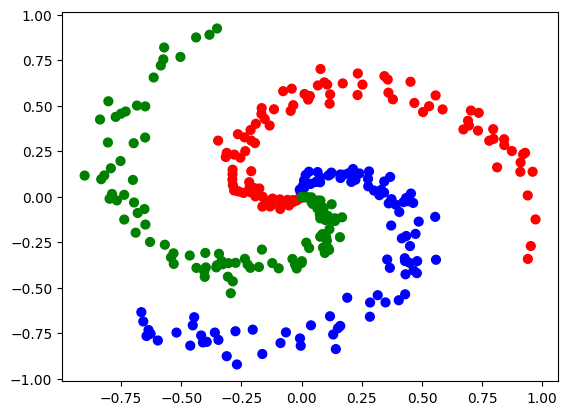

In [17]:
# lets visualize the data:
X , y = generate_spiral()
colors = ['blue','red','green']
cmap = ListedColormap(colors)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=cmap)
plt.show()

### The MLP Model Class

- PyTorch does not provide an in-built fit / train method. So we need to define one.

In [18]:
#optimizer utility function
def train_model(model: torch.nn,
                X: torch.tensor, 
                y: torch.tensor, 
                eta: float =0.01,
                loss_fn = nn.CrossEntropyLoss()):
    """
    :param model: model definition
    :type model: torch.nn
    :param X: feature vector
    :type X: torch.tensor
    :param y: label vector
    :type y: torch.tensor
    :param eta: learning rate
    :type eta: float
    :param loss_fn: loss function
    :type loss_fn: callable
    :returns: None
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=eta)

    for _ in range(100):

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs,y)
        loss.backward()
        optimizer.step()

- Convenient init method to initialize with arbitrary layer size, hidden layer count, label count etc.

In [19]:
class MLP(nn.Module):

    def __init__(self,
                 feat_size:int,
                 hidden_layers:int,
                 layer_size: int,
                 label_size: int):
        super().__init__()
        layers = [nn.Linear(feat_size,layer_size),nn.ReLU()]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.ReLU())

        layers.extend([nn.Dropout(p=0.0),nn.Linear(layer_size,label_size)])
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        """Forward pass"""
        return self.layers(x)

In [20]:
X_tens, y_tens = prep_for_torch(X,y)

mlp = MLP(feat_size=2,
          hidden_layers=5, 
          layer_size=100,
          label_size=3
          )

train_model(
    mlp,
    X_tens,
    y_tens
)

outputs = torch.argmax(mlp(X_tens),dim=1)

error_rate = 100 * (len(y) - np.equal(outputs,y.T).sum())/len(y)
print(f"Success Rate: {100 - error_rate:.2f}% || Error Rate: {error_rate:.2f}%")

Success Rate: 99.33% || Error Rate: 0.67%


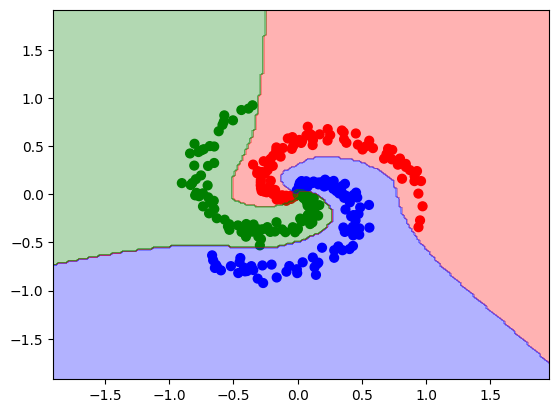

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=cmap)
draw_decision_boundary(mlp, X)
plt.show()

Generate a new Spiral, and see if the model generalizes well.

Success Rate: 98.67% || Error Rate: 1.33%


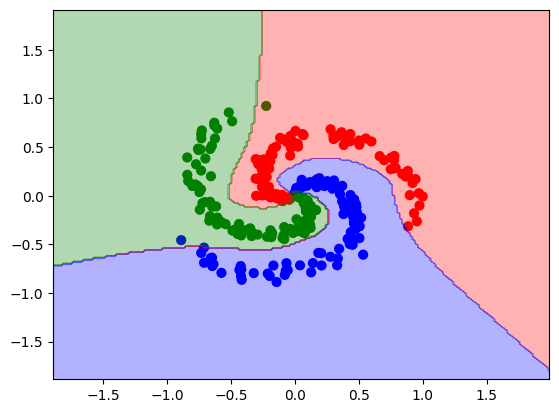

In [22]:
X,y = generate_spiral()
X_tens, y_tens = prep_for_torch(X,y)

outputs = torch.argmax(mlp(X_tens),dim=1)

error_rate = 100 * (len(y) - np.equal(outputs,y.T).sum())/len(y)
print(f"Success Rate: {100 - error_rate:.2f}% || Error Rate: {error_rate:.2f}%")

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=cmap)
draw_decision_boundary(mlp, X)
plt.show()

The model is only slightly worse on the second dataset. We can say that the model generalizes well.

<h4 id=[

##### Load The Dataset

In [23]:
def display_assortment(data,width=4, height=5):
    """plot a random assortment of images from the 
    given minst dataset"""
    fig, axs = plt.subplots(width, height)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    for ax in axs:
        for a in ax:
            img, label = data[random.randint(0, len(data))]
            img = np.array(img,dtype=float).reshape((28,28))
            a.imshow(
                img,
                cmap='Greys',
                interpolation='nearest'
            )
            a.title.set_text(label)
            a.set_xticks([])
            a.set_yticks([])

    

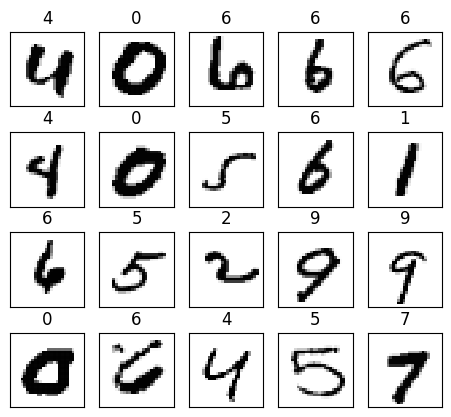

In [24]:
train_data = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

display_assortment(train_data)

##### Model Class

In [25]:
from collections import OrderedDict

class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(OrderedDict([
            ["Convl1",nn.Conv2d(1, 32, 3, 1)],
            ["Relu1", nn.ReLU()],
            ["Convl2", nn.Conv2d(32,64, 3, 1)],
            ["Relu2", nn.ReLU()],
            ["Pool1", nn.MaxPool2d(2)],
            ["drop1",nn.Dropout(0.25)],
            ["flatten",nn.Flatten()],
            ["lin1",nn.Linear(9216,128)],
            ["Relu3", nn.ReLU()],
            ["drop2",nn.Dropout(0.5)],
            ["lin2", nn.Linear(128,10)],
            ["output", nn.LogSoftmax(dim=1)]
            
        ]))

    def forward(self, x):
        """"""
        return self.layers(x)

##### Model training Function

In [26]:
#optimizer utility function
def train_model(model: torch.nn,
                data_loader,
                device,
                eta: float =0.001,
                epoch: int = 10,
                loss_fn = nn.CrossEntropyLoss()):
    """
    :param model: model definition
    :type model: torch.nn
    :param X: feature vector
    :type X: torch.tensor
    :param y: label vector
    :type y: torch.tensor
    :param eta: learning rate
    :type eta: float
    :param loss_fn: loss function
    :type loss_fn: callable
    :returns: None
    """
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=eta)
    for _ in range(epoch):
        print(f"Starting {_}/{epoch}\r\n")
        for idx, (input, labels) in enumerate(data_loader):
            optimizer.zero_grad()
            outputs = model(input.to(device))
            loss = loss_fn(outputs,labels.to(device))
            loss.backward()
            optimizer.step()

#test function
def test_model(model: torch.nn,
               data_loader,
               device,
               loss_fn = nn.CrossEntropyLoss()
               ):
    """"""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(data_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
def visualize_filters(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")
cnn = CNN().to(device)

training_loader = DataLoader(train_data, batch_size=64,shuffle=True)
test_loader = DataLoader(test_data)
cnn.load_state_dict(torch.load("mnist.ckpt"))
# train_model(cnn,
#             training_loader,
#             device)

# torch.save(cnn.state_dict(), "mnist.ckpt")

test_model(cnn, test_loader, device)

Device is cuda

Test set: Average loss: 0.0285, Accuracy: 9920/10000 (99%)



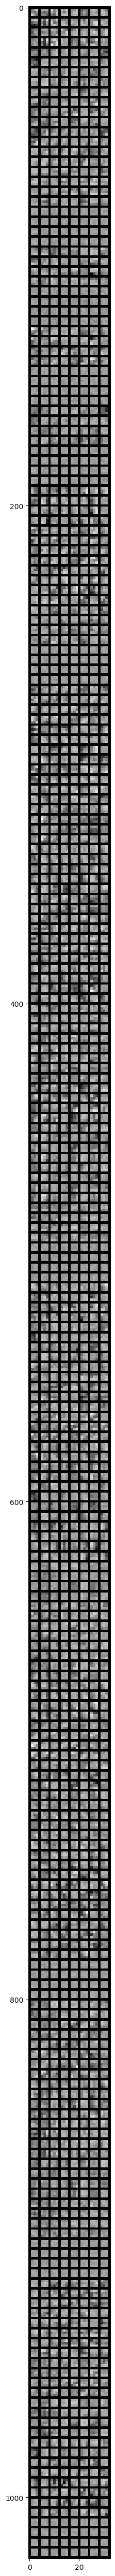

In [36]:
layer = 1
filter = cnn.layers[2].weight.data.clone().to("cpu")
visualize_filters(filter, ch=0, allkernels=False)